# Red wine quality prediction

Re-formulated as a classification problem.

Apply weight on the objective function to balance data.

Test different loss functions.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

## Load the data

In [2]:
data = pd.read_csv('./data/winequality-red.csv')

## Pre-process the data

1. Check missing data - none
2. Drop the irrelevant columns - unecessary in this case
3. Ensure data types are correct
3. Encode the categorical columns
4. Normalize the continuous columns
5. Put back the categorical and continuous columns together
6. Split the data into a training set and a validation set

In [11]:
# only continuous columns exist
X_all = data.drop('quality', axis = 1).values
X_all = (X_all - X_all.mean()) / X_all.std()

# note here - the wine quality is divided into 2 imbalanced groups
y_all = (data['quality'].values >= 7).astype(np.int32)
print(f'Good wines: {np.sum(y_all == 1)}, Bad wines: {np.sum(y_all == 0)}')

Good wines: 217, Bad wines: 1382


## Find the weight by counting the number of samples in each category

In [3]:
weight = np.ones(y_all.shape[0])
freq = 1 / data['quality'].value_counts()
for i in freq.index:
    weight[data['quality'] == i] = freq[i]
weight = weight / weight.mean()
print(weight)

[0.39133627 0.39133627 0.39133627 ... 0.4177116  0.39133627 0.4177116 ]


In [8]:
# add a weight column so that it will be split up properly with the train and test
X_all = np.concatenate([X_all, weight.reshape(-1,1)], axis = 1)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.2, random_state = 0)

# convert stuff to torch tensors so they can be used in PyTorch training
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# separate the weight column
weight_train = X_train[:, -1]
X_train = X_train[:,:-1]
weight_test = X_test[:, -1]
X_test = X_test[:,:-1]

array([0, 0, 0, ..., 1, 0, 1])

## Define the neural network architecture

In [9]:
class ANNModel(nn.Module):

    def __init__(self, in_size, out_size, hidden_sizes, p):
        super().__init__()

        layerlist = []
        for i in hidden_sizes:
            layerlist.append(nn.Linear(in_size,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            in_size = i
        layerlist.append(nn.Linear(hidden_sizes[-1], out_size))

        self.layers = nn.Sequential(*layerlist)

    def forward(self, x):
        x = self.layers(x)
        return x

## Define other stuff needed to train the neural network model

In [10]:
torch.manual_seed(33)

# Test multiple loss functions, allowing weights to be passed in
def custom_loss(input, target, weight = None, type = 'mse', v = 0.04):
    if weight is None:
        weight = torch.ones(input.shape[0])

    if type == 'mse':
        return (weight * (input - target)**2).mean()
    elif type == 'mae':
        return (weight * torch.abs(input - target)).mean()
    elif type == 'kge':
        x = torch.hstack([input, target.reshape(-1,1)]).T
        cost = (torch.corrcoef(x)[0,1] - 1) ** 2 + \
               (torch.mean(input)/torch.mean(target) - 1) ** 2 + \
               (torch.std(input)/(torch.std(target)+1e-12) -  1) ** 2
        return cost
    elif type == 'corr':
        x = torch.hstack([input, target.reshape(-1,1)]).T
        cost = - torch.corrcoef(x)[0,1]
        if torch.isnan(cost):
            cost = 0
        return cost
    elif type == 'corr1':
        x = torch.hstack([input, target.reshape(-1,1)]).T
        cost = - torch.corrcoef(x)[0,1]
        if torch.isnan(cost):
            cost = 0
        else:
            cost = cost + v * ( torch.abs(input.max()-target.max()) + torch.abs(input.min()-target.min()) )
        return cost


# feed the data into the model by batches
train_dataloader = DataLoader([(X_train[i,:], weight_train[i], y_train[i]) \
                               for i in range(X_train.shape[0])],
                               batch_size=512, shuffle=True)

# these are moved below
# number of times to train the model
# record the loss for each epoch
# the optimizer to find weights

## Train the model on training data

* Loop 1: MSE Loss w/ weighted objective function (same as week 1 except for weighting)

Below use weighted random sampler, which samples with replacement
* Loop 2: MSE Loss (same as week 1 except for weighting)
* Loop 3: MSE Loss (same as above w/ epoch = 450 for overfitting)
* Loop 4: MAE Loss (illustrate alternative loss function)
* Loop 5: KGE loss (illustrate alternative loss function)
* Loop 6: Correlation loss (illustrate custom loss function)
* Loop 7: Hybrid loss of correlation and range (v = 0.02)
* Loop 8: Hybrid loss of correlation and range (v = 0.1 to illustrate trade-off)

Loop 1 =========================================================
epoch:  99  loss: 3.11034799

Duration: 4 seconds
Loop 2 =========================================================
epoch: 149  loss: 2.96082425

Duration: 10 seconds
Loop 3 =========================================================
epoch: 449  loss: 1.06159508

Duration: 15 seconds
Loop 4 =========================================================
epoch: 149  loss: 1.00087619

Duration: 6 seconds
Loop 5 =========================================================
epoch: 449  loss: 0.36009714

Duration: 13 seconds
Loop 6 =========================================================
epoch: 149  loss: -0.52975279

Duration: 6 seconds
Loop 7 =========================================================
epoch: 449  loss: -0.49080837

Duration: 12 seconds
Loop 8 =========================================================
epoch: 449  loss: -0.23980224

Duration: 17 seconds


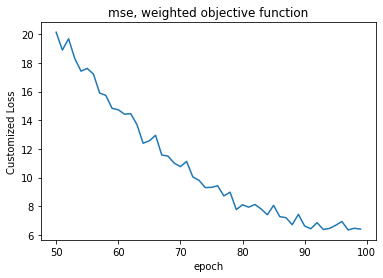

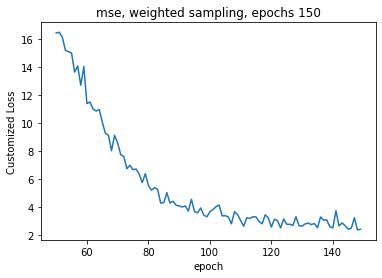

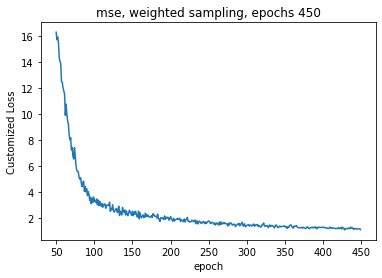

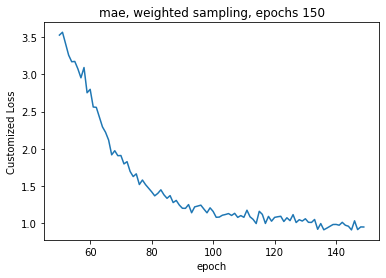

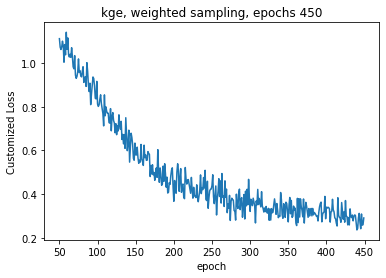

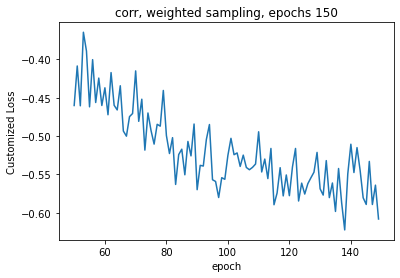

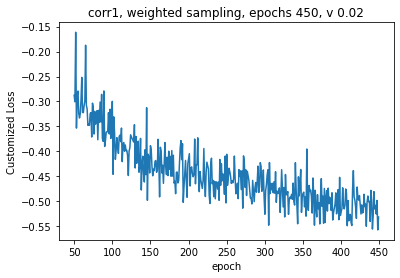

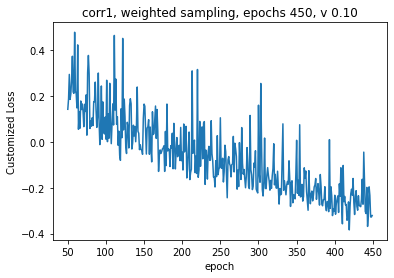

In [11]:
sampler = WeightedRandomSampler(weight_train, 
                                num_samples=len(weight_train), replacement=True)

###############################################################################
print('Loop 1 =========================================================')

model = ANNModel(X_train.shape[1], 1, [50, 50, 50], p = 0.4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100
losses = []

start_time = time.time()
for i in range(epochs):
    for j in range(0, X_train.shape[0], 512):
        # make a prediction
        y_pred = model(X_train[j:(j+512),:])

        # calculate the loss and record it
        loss = custom_loss(y_pred, y_train[j:(j+512)], weight_train[j:(j+512)], type = 'mse')
        if j == 0:
            losses.append(loss.detach().numpy())

        # set the gradients to zero
        optimizer.zero_grad()

        # calculate the gradients
        loss.backward()

        # let the optimizer update the weights
        optimizer.step()
print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

# save the model
if len(losses) == epochs:
    torch.save(model.state_dict(), 'RedWineModel_1.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

# plot the loss
fig, ax = plt.subplots()
ax.plot(range(50, len(losses)), losses[50:])
ax.set_ylabel('Customized Loss')
ax.set_xlabel('epoch')
ax.set_title('mse, weighted objective function')

###############################################################################
for k, type in enumerate(['mse','mse','mae','kge','corr','corr1','corr1'], 1):
    print('Loop {} ========================================================='.format(k+1))
    model = ANNModel(X_train.shape[1], 1, [50, 50, 50], p = 0.4)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    if (k == 2) or (k == 4) or (k >= 6):
        epochs = 450
    else:
        epochs = 150
    if k == 6:
        v = 0.02
    else:
        v = 0.1

    losses = []
    start_time = time.time()
    for i in range(epochs):
        for j, (train_x, train_w, train_y) in enumerate(train_dataloader):
            # make a prediction
            y_pred = model(train_x)

            # calculate the loss and record it
            loss = custom_loss(y_pred, train_y, None, type, v)

            if j == 0:
                losses.append(loss.detach().numpy())

            # set the gradients to zero
            optimizer.zero_grad()

            # calculate the gradients
            loss.backward()

            # let the optimizer update the weights
            optimizer.step()

    print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

    # save the model
    if len(losses) == epochs:
        torch.save(model.state_dict(), 'RedWineModel_{}.pt'.format(k+1))
    else:
        print('Model has not been trained. Consider loading a trained model instead.')

    # plot the loss
    fig, ax = plt.subplots()
    ax.plot(range(50, len(losses)), losses[50:])
    ax.set_ylabel('Customized Loss')
    ax.set_xlabel('epoch')
    if k >= 6:
        ax.set_title('{}, weighted sampling, epochs {}, v {:.2f}'.format(type, epochs, v))
    else:
        ax.set_title('{}, weighted sampling, epochs {}'.format(type, epochs))

## Evaluate the model on the test set

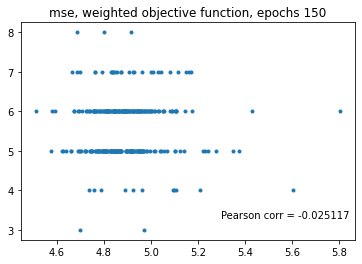

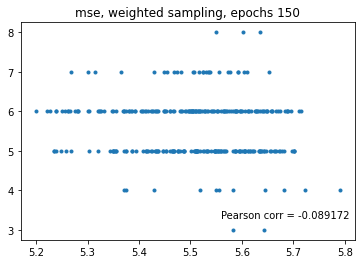

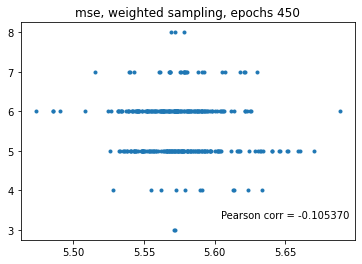

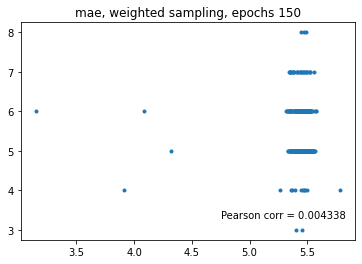

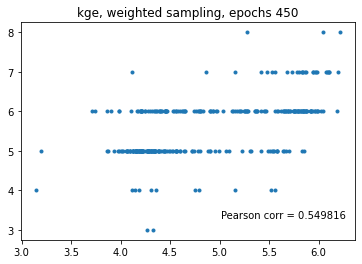

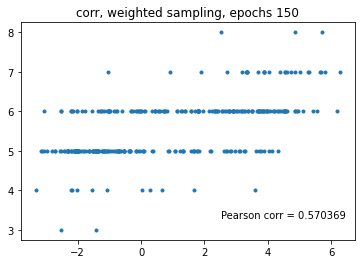

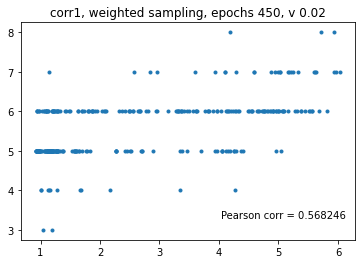

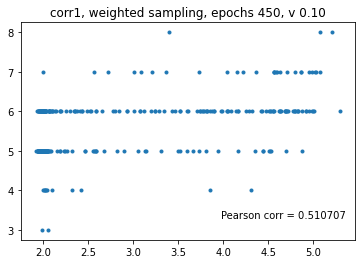

In [12]:
for k,type in enumerate(['mse','mse','mse','mae','kge','corr','corr1','corr1']):
    if (k == 2) or (k == 4) or (k >= 6):
        epochs = 450
    else:
        epochs = 150
    if k == 6:
        v = 0.02
    else:
        v = 0.1

    # To load the model
    model2 = ANNModel(X_train.shape[1], 1, [50, 50, 50], p = 0.4)
    model2.load_state_dict(torch.load('RedWineModel_{}.pt'.format(k+1)))
    model2.eval() # make sure to run this step!

    with torch.no_grad():
        y_val = model2(X_test)
        loss = custom_loss(y_val, y_test, weight_test, 'corr')

    fig, ax = plt.subplots()
    ax.plot(y_val, y_test, '.')
    ax.text(0.6,0.1,f'Pearson corr = {-loss:.6f}',transform = ax.transAxes)

    if k == 0:
        ax.set_title('{}, weighted objective function, epochs {}'.format(type, epochs))
    elif k >= 6:
        ax.set_title('{}, weighted sampling, epochs {}, v {:.2f}'.format(type, epochs, v))
    else:
        ax.set_title('{}, weighted sampling, epochs {}'.format(type, epochs))